# Intro to Python

As a demo of the language, plot sin and cos on the same axis:

In [2]:
# load some key packages:
import numpy as np                # a numerical package
import pandas as pd               # a data analysis package
import matplotlib.pyplot as plt   # a plotting package

# to display the plots in the same document
%matplotlib inline

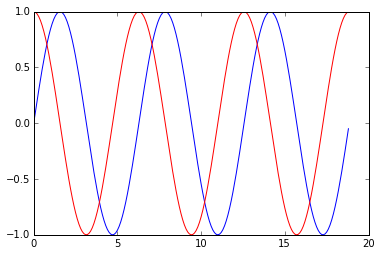

In [3]:
# define an array of points (start, end, by)
x = np.arange(0,6*np.pi,0.1)

# plot the sin of these points
plt.plot(x, np.sin(x), 'b')

# plot the cos of these points
plt.plot(x, np.cos(x),'r')

# Netcdf

There are several different tools for working with netcdf data using python. This example focuses on xarray, because the time capabilities are really impressive. If you know the url of the dataset that you are interested in, you can display read the info about that datset using **xarray.open_dataset(data_url)** and then printing the outcome. To work with the file, we will assign that dataset to a name -in this example we will use **ds**.

In [4]:
# load some the netcdf-handling package:
import xarray as xr

data_url = 'http://hydromet-thredds.princeton.edu/thredds/dodsC/MonitoringStations/CR1000_Table1.nc'
variable = 'AirTC_Avg'

ds = xr.open_dataset(data_url)

At this point you haven't pulled over any actual data, you just have a way of referencing the dataset. To pull data we just select the part of the dataset that we are interested in. In this case AirTC_Avg.

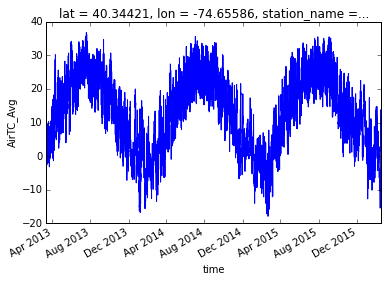

In [5]:
ds[variable].plot()

## Time slices

We often are more interested in looking at one particular time, rather than the whole record. In xarray there are several different equivalent indexing techniques. Here is one:

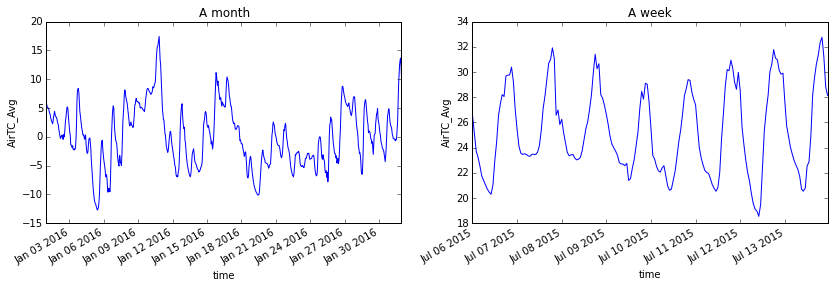

In [163]:
# slice the dataset or choose a date period (such as a month)
a_month = ds[variable].sel(time='2016-01')
a_week =  ds[variable].sel(time=slice('2015-07-06', '2015-07-13'))

# plot the slice
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14,4))

a_month.plot(ax=axes[0])
axes[0].set_title('A month')

a_week.plot(ax=axes[1])
axes[1].set_title('A week')

plt.show()

## Multiple variables

In [165]:
# slice the dataset by time and grab variables of interest
vars_for_a_week = ds[['Rain_mm_3_Tot', 'VW']].sel(time=slice('2015-07-06', '2015-07-13'))

To plot several variables over a defined period of time, we can use a list of variables, and a slice of time to generate a pandas.DataFrame. Then we can drop the columns that contain info that we don't need.

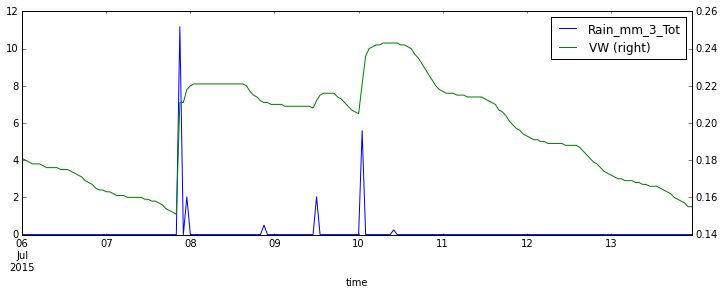

In [169]:
# convert to pandas.dataframe
df = vars_for_a_week.to_dataframe()

# drop columns that we aren't interested in 
df = df.drop(['lat','lon', 'station_name'], axis=1)

# plot
df.plot(secondary_y='VW', figsize=(12,4))
plt.show()

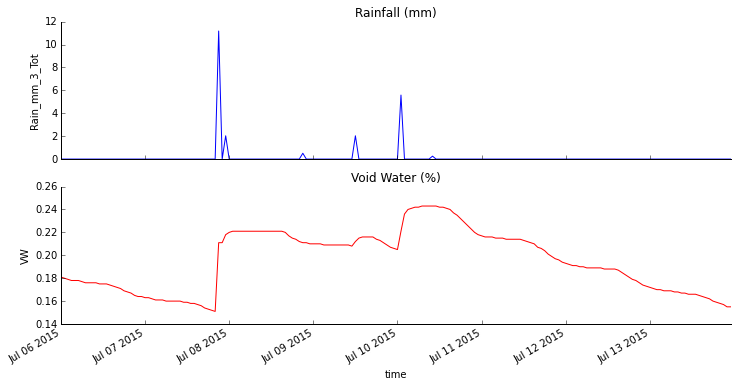

In [170]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,6), sharex=True)
variables = ['Rain_mm_3_Tot', 'VW']
titles = ['Rainfall (mm)', 'Void Water (%)']
colors = ['b','r']

for var, ax, title, c in zip(variables, axes, titles, colors):
    vars_for_a_week[var].plot(ax=ax, c=c)
    ax.set_title(title)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

plt.show()

## Rainy days

In [93]:
ds_wet_day = ds['Rain_mm_3_Tot'].resample('1D','time', how='sum', label='right')
wettest = ds_wet_day.to_pandas().sort_values(ascending=False)
wettest.head()

time
2014-05-01    70.614
2013-11-28    70.360
2013-06-08    64.008
2014-07-16    63.498
2014-05-02    57.146
dtype: float64

In [179]:
rainy_day = ds[['Rain_mm_3_Tot', 'VW']].sel(time=slice('2014-04-29', '2014-05-01'))

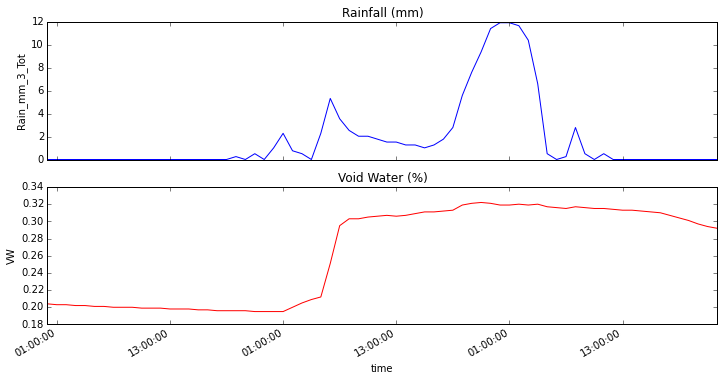

In [190]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12,6), sharex=True)

rainy_day['Rain_mm_3_Tot'].plot(ax=axes[0], c='b')
axes[0].set_title('Rainfall (mm)')

rainy_day['VW'].plot(ax=axes[1], c='r')
axes[1].set_title('Void Water (%)')

plt.show()

## Rain on wet soil

In [202]:
rain_on_wet_soil = ds.where(ds['Rain_mm_3_Tot']>0).where(ds['VW']>.25).where(ds['AirTC_Avg']>10).dropna('time')

In [209]:
df = rain_on_wet_soil[['Rain_mm_3_Tot', 'VW', 'AirTC_Avg']].to_dataframe()

In [211]:
df = df.drop(['lat', 'lon', 'station_name'], axis=1)

## Monthly rainfall

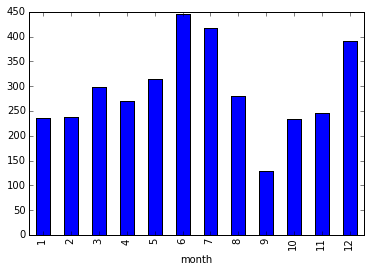

In [92]:
monthly_rainfall = ds['Rain_mm_3_Tot'].groupby('time.month').sum('time').to_pandas()
monthly_rainfall.plot.bar()